In [3]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 
from keras.models import model_from_json
from skimage.transform import resize
import matplotlib.image as image
from skimage import color
from time import time
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import math
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from skimage.transform import rescale, resize, downscale_local_mean

In [44]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)       
    img = ds.pixel_array
    
    #plt.imshow(img)
    print(f'ID: {ds.PatientID}')
    print(f'Sex: {ds.PatientSex}')
    print(f'Age: {ds.PatientAge}')
    print(f'Modality: {ds.Modality}')
    print(f'Study Description: {ds.StudyDescription}')
    print(f'Rows: {ds.Rows}')
    print(f'Columns: {ds.Columns}')
    
    #Checking for other important fields 
    
    # Age
    age = int(ds.PatientAge)
    if age < 2 or age > 112:
        print(f'Image {filename} not included, Age: {age}')
    
    # Body Part
    body_part = ds.BodyPartExamined
    if body_part not in ['CHEST', 'chest','RIBCAGE']:
        print(f'Image {filename} not included, Body part: {body_part}')
    
    # Patient Position
    pos = ds.PatientPosition
    if pos not in ['PA', 'AP']:
        print(f'Image {filename} not included, Patient position: {pos}')
    
    # Image Modality 
    mod = ds.Modality                            
    if mod != 'DX':
        print(f'Image {filename} not included, Modality: {mod}')
        
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_size): 
    
    print(f'Image data: {img.shape}')

    resized_img = resize(img, (img_size[1], img_size[2]))
    print(f'Resized data: {resized_img.shape}')

    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)
    print(f'Processed data: {proc_img.shape}')

    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    
    json_file = open(model_path, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)

    # load weights into new model
    model.load_weights(weight_path)
    print(f"Model loaded: {model}")

    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
      
    prediction = model(img)
    
    if(prediction > thresh):
        prediction = 'Pneumonia'
    else:
        prediction = "No Pneumonia"
    
    return prediction 

In [45]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json'
weight_path = 'xray_class_my_model.best.hdf5'

IMG_SIZE=(1,512,512,3) # This might be different if you did not use vgg16
# img_mean = # loads the mean image value used during training preprocessing
# img_std = # loads the std dev image value used during training preprocessing

my_model = load_model(model_path, weight_path)
thresh = 0.4

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)

Model loaded: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4e32d11f50>
Load file test1.dcm ...
ID: 2
Sex: M
Age: 81
Modality: DX
Study Description: No Finding
Rows: 1024
Columns: 1024
Image data: (1024, 1024)
Resized data: (512, 512)
Processed data: (1, 512, 512, 3)
No Pneumonia
Load file test2.dcm ...
ID: 1
Sex: M
Age: 58
Modality: DX
Study Description: Cardiomegaly
Rows: 1024
Columns: 1024
Image data: (1024, 1024)
Resized data: (512, 512)
Processed data: (1, 512, 512, 3)
Pneumonia
Load file test3.dcm ...
ID: 61
Sex: M
Age: 77
Modality: DX
Study Description: Effusion
Rows: 1024
Columns: 1024
Image data: (1024, 1024)
Resized data: (512, 512)
Processed data: (1, 512, 512, 3)
Pneumonia
Load file test4.dcm ...
ID: 2
Sex: M
Age: 81
Modality: DX
Study Description: No Finding
Rows: 1024
Columns: 1024
Image data: (1024, 1024)
Resized data: (512, 512)
Processed data: (1, 512, 512, 3)
No Pneumonia
Load file test5.dcm ...
ID: 2
Sex: M
Age: 81
Modality: CT
Study Description

Load file test1.dcm ...
ID: 2
Sex: M
Age: 81
Modality: DX
Study Description: No Finding
Rows: 1024
Columns: 1024


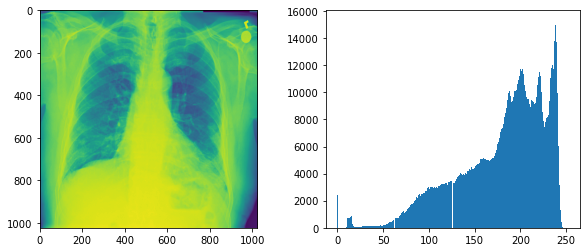

Load file test2.dcm ...
ID: 1
Sex: M
Age: 58
Modality: DX
Study Description: Cardiomegaly
Rows: 1024
Columns: 1024


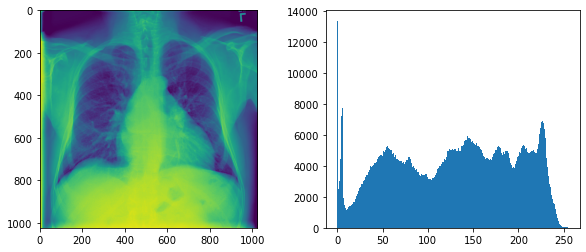

Load file test3.dcm ...
ID: 61
Sex: M
Age: 77
Modality: DX
Study Description: Effusion
Rows: 1024
Columns: 1024


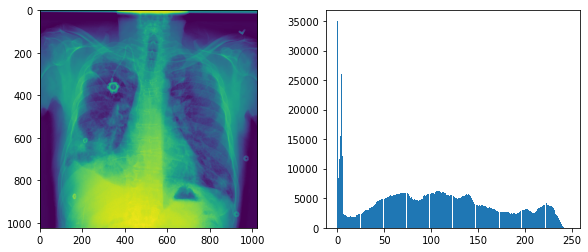

Load file test4.dcm ...
ID: 2
Sex: M
Age: 81
Modality: DX
Study Description: No Finding
Rows: 1024
Columns: 1024


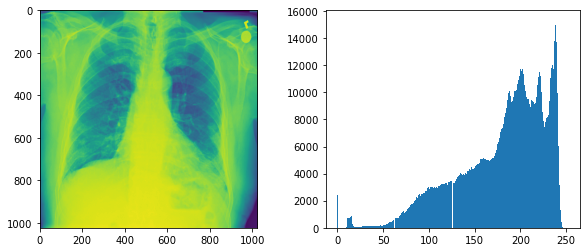

Load file test5.dcm ...
ID: 2
Sex: M
Age: 81
Modality: CT
Study Description: No Finding
Rows: 1024
Columns: 1024
Image test5.dcm not included, Modality: CT


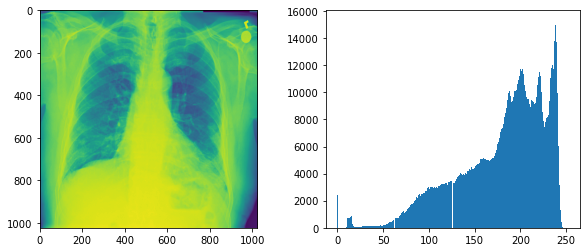

Load file test6.dcm ...
ID: 2
Sex: M
Age: 81
Modality: DX
Study Description: No Finding
Rows: 1024
Columns: 1024
Image test6.dcm not included, Patient position: XX


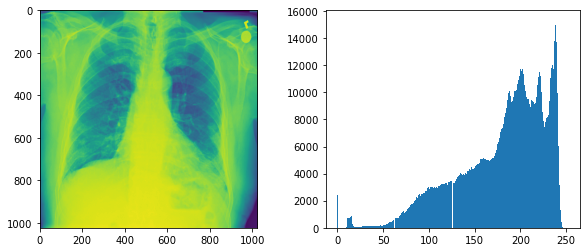

In [47]:
#Testing predictions 
    
for i,filename in enumerate(test_dicoms):
    pred = check_dicom(filename)
    img = pydicom.dcmread(filename).pixel_array        
    f = plt.figure()
    f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    f.add_subplot(1, 2, 2)
    plt.hist(img.flatten(), bins=256)
    plt.show()
    